# Analyse ROMY Events

In [1]:
import os
import numpy as np
import obspy as obs
import matplotlib
import matplotlib.pyplot as plt

from sixdegrees.sixdegrees import sixdegrees


## Configurations

In [2]:
config = sixdegrees.load_from_yaml("./config/config_ROMY_M8.8_20250729")

Setup a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Get key information about the event

In [4]:
ev = sd.get_event_info(
    origin_time=config['origin_time'],
    base_catalog="USGS",
    magnitude=config['magnitude']
)


Found event:
Origin time: 2025-07-29T23:24:52.480000Z
Magnitude: 8.8 mww
Location: 52.498°N, 160.264°E
Depth: 35.0 km
Epicentral Distance: 8469.0 km
Epicentral Distance: 76.2°
Backazimuth: 18.9°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [5]:
st_load = obs.read("./data/romy_eigenmodes.mseed")

sd.st0 = st_load
sd.st = sd.st0

del st_load

Ensure that all traces of stream have the same sample size

In [6]:
# matplotlib.use('TkAgg')

In [7]:
sd.trim_stream(set_common=True, set_interpolate=False)

 -> stream size inconsistent: [5184041, 5184041, 5184041, 5184041, 5184040, 5184041]
  -> adjusted: [5184040, 5184040, 5184040, 5184040, 5184040, 5184040]


In [8]:
# remove actual event
sd.st.trim(sd.tbeg+4*3600, sd.tend-9*3600)

6 Trace(s) in Stream:
XX.ROMY..BHZ | 2025-07-30T03:29:59.989999Z - 2025-08-01T14:29:59.989999Z | 20.0 Hz, 4248001 samples
XX.ROMY..BHN | 2025-07-30T03:29:59.989999Z - 2025-08-01T14:29:59.989999Z | 20.0 Hz, 4248001 samples
XX.ROMY..BHE | 2025-07-30T03:29:59.989999Z - 2025-08-01T14:29:59.989999Z | 20.0 Hz, 4248001 samples
XX.ROMY..BJU | 2025-07-30T03:30:00.000001Z - 2025-08-01T14:30:00.000001Z | 20.0 Hz, 4248001 samples
XX.ROMY..BJV | 2025-07-30T03:29:59.981200Z - 2025-08-01T14:29:59.981200Z | 20.0 Hz, 4248001 samples
XX.ROMY..BJZ | 2025-07-30T03:29:59.985200Z - 2025-08-01T14:29:59.985200Z | 20.0 Hz, 4248001 samples

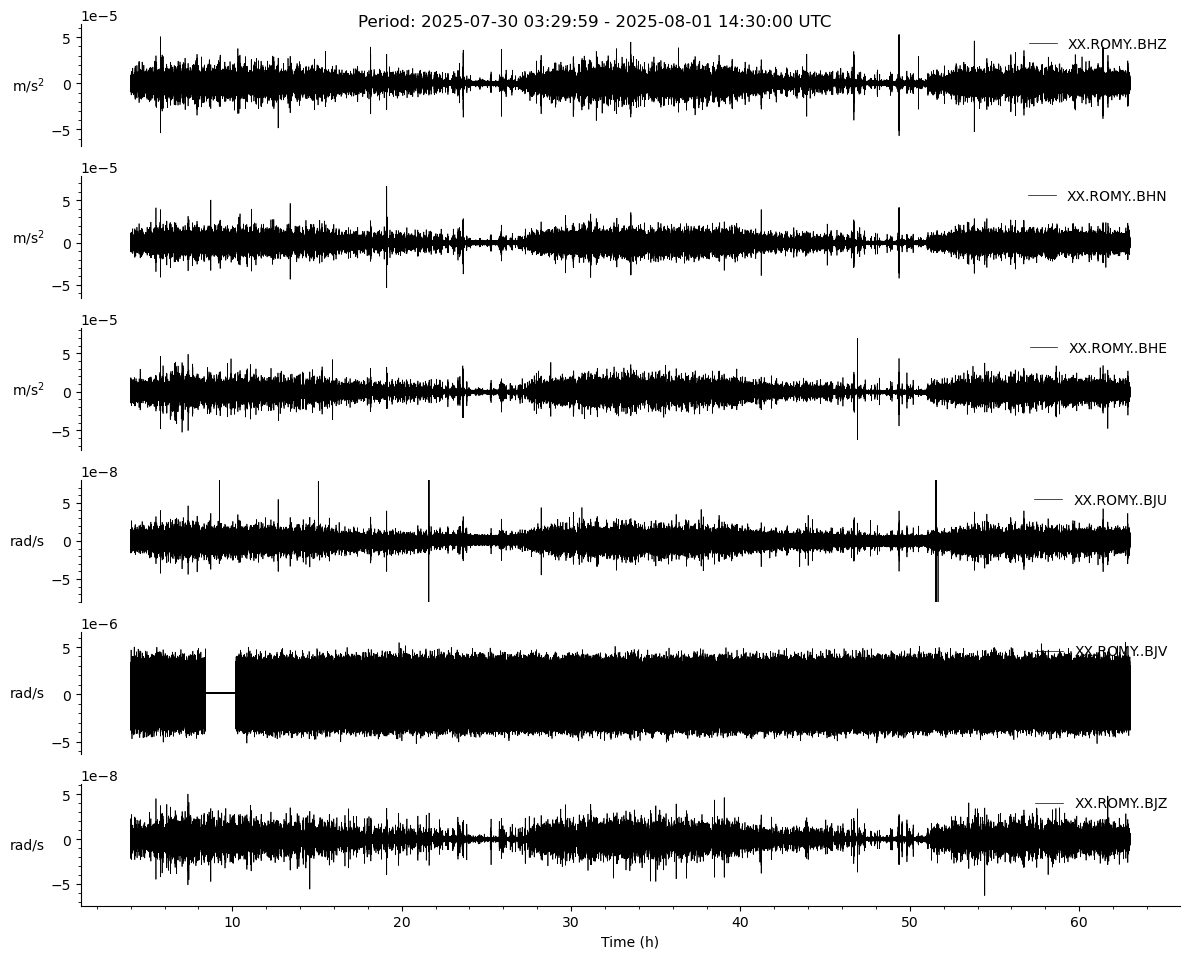

In [9]:
fig = sd.plot_waveforms(time_scale="hours", ybounds={"BJU": (-8e-8, 8e-8)})

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  plt.setp(ax.get_xticklabels(), fontsize='small',


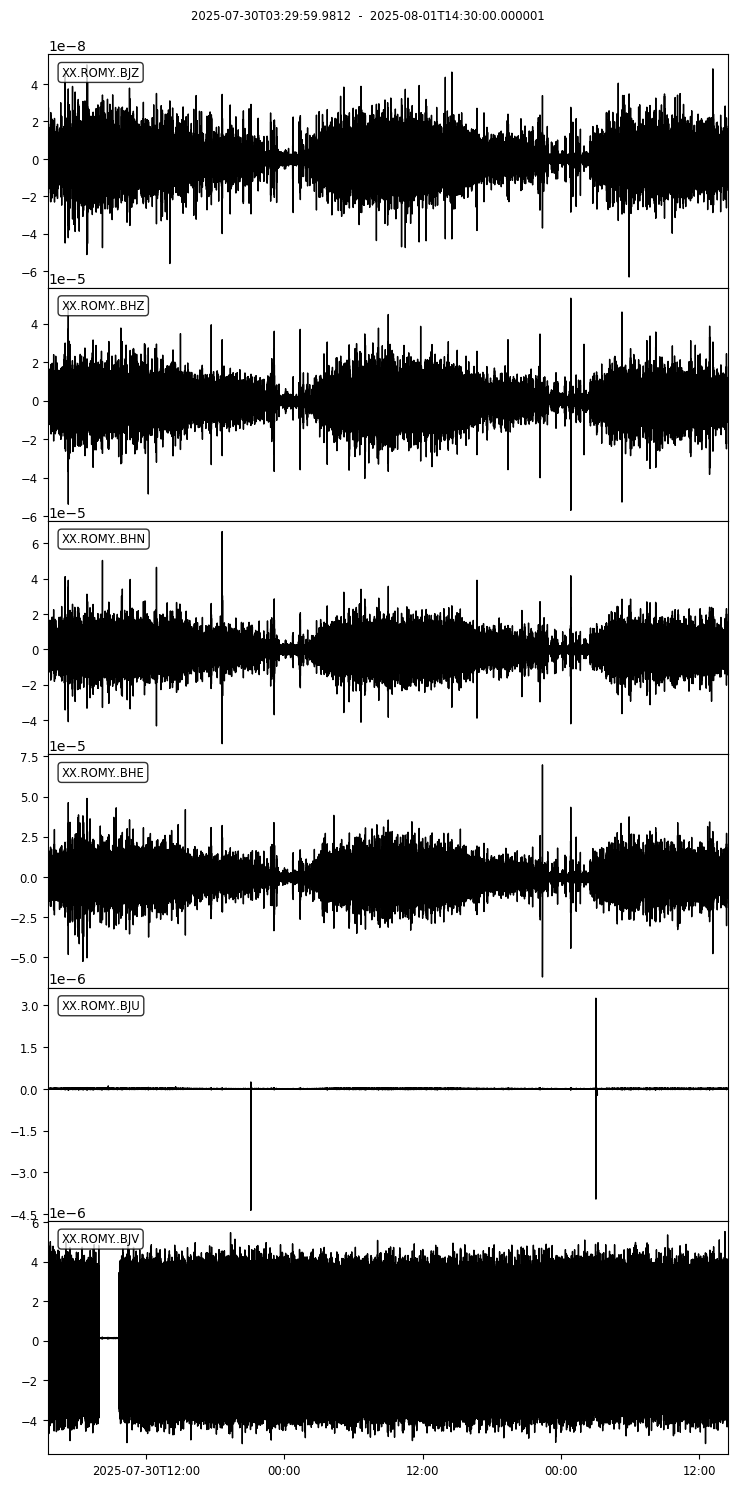

In [10]:
sd.st.plot(equal_scale=False, method="full");

### Fill Gaps

In [11]:
def fill_gap_with_white_noise(stream, gap_start_time, gap_end_time, window_size_sec=100, plot=False, plot_window_sec=30, method='time'):
    """
    Fill a gap in an ObsPy Stream with white noise that matches the characteristics 
    of the surrounding data.
    
    Parameters
    ----------
    stream : obspy.Stream
        Input stream containing the data with gaps
    gap_start_time : str or UTCDateTime
        Start time of the gap
    gap_end_time : str or UTCDateTime
        End time of the gap
    window_size_sec : float, optional
        Size of the windows before and after the gap to analyze for noise characteristics
        in seconds. Default is 100 seconds.
    plot : bool, optional
        If True, shows a comparison plot of the original and filled data. Default is False.
    plot_window_sec : float, optional
        Time window in seconds to show before and after the gap in the plot. Default is 30 seconds.
    method : str, optional
        Method for gap filling: 'time' (original method) or 'frequency' (spectral interpolation).
        Default is 'time'.
        
    Returns
    -------
    obspy.Stream
        Stream with the gap filled with synthetic noise
    """
    from obspy import UTCDateTime, Stream
    import numpy as np
    from scipy import signal, fft
    import matplotlib.pyplot as plt
    
    # Convert time strings to UTCDateTime if needed
    gap_start = UTCDateTime(gap_start_time)
    gap_end = UTCDateTime(gap_end_time)
    
    # Create a copy of the input stream
    filled_stream = stream.copy()
    original_stream = stream.copy()  # Keep a copy for plotting
    
    # Process each trace in the stream
    for tr in filled_stream:
        # Skip if trace doesn't overlap with the gap
        if tr.stats.endtime < gap_start or tr.stats.starttime > gap_end:
            continue
            
        # Calculate sample indices for the gap
        gap_start_idx = int((gap_start - tr.stats.starttime) * tr.stats.sampling_rate)
        gap_end_idx = int((gap_end - tr.stats.starttime) * tr.stats.sampling_rate)
        
        # Calculate window size in samples
        window_samples = int(window_size_sec * tr.stats.sampling_rate)
        
        # Adjust window size if it's too large
        window_samples = min(
            window_samples, 
            gap_start_idx,  # data available before gap
            len(tr.data) - gap_end_idx  # data available after gap
        )

        if window_samples < 10:  # Skip if windows are too small
            continue
            
        # Get data windows before and after the gap
        pre_gap = tr.data[gap_start_idx - window_samples:gap_start_idx]
        post_gap = tr.data[gap_end_idx:gap_end_idx + window_samples]
        

        # Calculate RMS amplitude of surrounding data
        pre_rms = np.sqrt(np.mean(pre_gap**2))
        post_rms = np.sqrt(np.mean(post_gap**2))
        
        # Calculate gap length in samples
        gap_length = gap_end_idx - gap_start_idx
        
        if method == 'frequency':
            pre_gap_demeaned = pre_gap - np.mean(pre_gap)
            post_gap_demeaned = post_gap - np.mean(post_gap)

            pre_gap_demeaned_taper = pre_gap_demeaned * signal.windows.hann(len(pre_gap_demeaned))
            post_gap_demeaned_taper = post_gap_demeaned * signal.windows.hann(len(post_gap_demeaned))

            # Get FFT of pre and post gap windows
            pre_fft = fft.rfft(pre_gap_demeaned_taper)
            post_fft = fft.rfft(post_gap_demeaned_taper)
            
            # Calculate average power spectra
            pre_power = np.abs(pre_fft)
            post_power = np.abs(post_fft)
            avg_power = (pre_power + post_power) / 2
            
            # Generate random phases
            n_freqs = len(avg_power)
            random_phases = np.random.uniform(0, 2*np.pi, n_freqs)
            
            # Create synthetic spectrum
            synthetic_spectrum = avg_power * np.exp(1j * random_phases)
            
            # Generate time domain signal
            synthetic_signal = fft.irfft(synthetic_spectrum, gap_length)
            
            # Apply amplitude scaling
            amplitude_scale = np.linspace(pre_rms, post_rms, gap_length)
            synthetic_signal *= amplitude_scale / np.std(synthetic_signal)
            
            # Ensure smooth connection at boundaries
            start_offset = np.mean(tr.data[gap_start_idx - window_samples//10:gap_start_idx])
            end_offset = np.mean(tr.data[gap_end_idx:gap_end_idx + window_samples//10])
            offset_ramp = np.linspace(start_offset, end_offset, gap_length)
            
            filled_data = synthetic_signal + offset_ramp
            
        else:  # method == 'time'
            # Original time domain method
            rms_values = np.ones(gap_length)
            noise = np.random.normal(min(pre_rms, post_rms), max(pre_rms, post_rms), gap_length)
            scaled_noise = noise * rms_values
            filled_data = scaled_noise - np.linspace(pre_rms, post_rms, gap_length)

        # Fill pre gap data
        tr.data[gap_start_idx - window_samples:gap_start_idx] = pre_gap_demeaned

        # Fill the gap with the processed data
        tr.data[gap_start_idx:gap_end_idx] = filled_data
        
        # Create comparison plot if requested
        if plot:
            # Trim streams to plotting window
            plot_start = gap_start - plot_window_sec
            plot_end = gap_end + plot_window_sec
            
            st_before_plot = original_stream.copy().trim(plot_start, plot_end)
            st_filled_plot = filled_stream.copy().trim(plot_start, plot_end)
            
            # Create the plot
            plt.figure(figsize=(12, 6))
            
            # Plot original data
            plt.plot(
                st_before_plot[0].times(),
                st_before_plot[0].data, 
                label="Original",
                alpha=0.7
            )
            
            # Plot filled data
            plt.plot(
                st_filled_plot[0].times(),
                st_filled_plot[0].data,
                label="Filled",
                alpha=0.7
            )
            
            # Add gap indication
            gap_start_rel = (gap_start - plot_start)
            gap_end_rel = (gap_end - plot_start)
            
            ylim = plt.ylim()
            plt.axvspan(gap_start_rel, gap_end_rel, 
                       color='gray', alpha=0.2, label='Gap')
            
            plt.xlabel('Time [s]')
            plt.ylabel('Amplitude')
            plt.title(f'Gap Filling Result - {tr.id}\n'
                     f'Gap: {gap_start.strftime("%Y-%m-%d %H:%M:%S")} to {gap_end.strftime("%Y-%m-%d %H:%M:%S")}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    
    return filled_stream

In [12]:
def fill_gap_exponential(stream, gap_start_time, gap_end_time, window_size_sec=100, plot=False, plot_window_sec=30, seasonal_periods=None):
    """
    Fill a gap in an ObsPy Stream using Holt-Winters exponential smoothing with optional
    seasonal decomposition.
    
    Parameters
    ----------
    stream : obspy.Stream
        Input stream containing the data with gaps
    gap_start_time : str or UTCDateTime
        Start time of the gap
    gap_end_time : str or UTCDateTime
        End time of the gap
    window_size_sec : float, optional
        Size of the windows before and after the gap to analyze. Default is 100 seconds.
    plot : bool, optional
        If True, shows a comparison plot of the original and filled data. Default is False.
    plot_window_sec : float, optional
        Time window in seconds to show before and after the gap in the plot. Default is 30 seconds.
    seasonal_periods : int, optional
        Number of samples for seasonal period. If None, defaults to 60s at current sampling rate.
        
    Returns
    -------
    obspy.Stream
        Stream with the gap filled using exponential smoothing
    """
    from obspy import UTCDateTime
    import numpy as np
    from scipy import signal
    import matplotlib.pyplot as plt
    import pandas as pd
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from datetime import timedelta
    
    # Convert time strings to UTCDateTime if needed
    gap_start = UTCDateTime(gap_start_time)
    gap_end = UTCDateTime(gap_end_time)
    
    # Create a copy of the input stream
    filled_stream = stream.copy()
    original_stream = stream.copy()  # Keep a copy for plotting
    
    # Process each trace in the stream
    for tr in filled_stream:
        # Skip if trace doesn't overlap with the gap
        if tr.stats.endtime < gap_start or tr.stats.starttime > gap_end:
            continue
            
        # Calculate sample indices for the gap
        gap_start_idx = int((gap_start - tr.stats.starttime) * tr.stats.sampling_rate)
        gap_end_idx = int((gap_end - tr.stats.starttime) * tr.stats.sampling_rate)
        

        # Calculate window size in samples
        window_samples = int(window_size_sec * tr.stats.sampling_rate)
        
        # Adjust window size if it's too large
        window_samples = min(
            window_samples, 
            gap_start_idx,  # data available before gap
            len(tr.data) - gap_end_idx  # data available after gap
        )

        if window_samples < 10:  # Skip if windows are too small
            continue

        # remove mean of pre_gap data
        pre_gap_mean = np.mean(tr.data[gap_start_idx:gap_end_idx])
        tr.data[gap_start_idx:gap_end_idx] -= pre_gap_mean
            
        # Get data windows before and after the gap
        pre_gap = tr.data[gap_start_idx - window_samples:gap_start_idx]
        post_gap = tr.data[gap_end_idx:gap_end_idx + window_samples]
        
        # Create time indices using evenly spaced samples
        sample_rate = tr.stats.sampling_rate
        dt = 1.0 / sample_rate
        
        # Calculate number of samples
        n_samples_gap = gap_end_idx - gap_start_idx
        n_samples_window = len(pre_gap)
        
        # Create time indices as seconds from start
        pre_times = np.arange(n_samples_window) * dt
        gap_times = np.arange(n_samples_gap) * dt
        
        # Create pandas Series with numeric indices
        pre_series = pd.Series(pre_gap, index=np.arange(len(pre_gap)))
        post_series = pd.Series(post_gap, index=np.arange(len(post_gap)))
        
        # Set seasonal period
        if seasonal_periods is None:
            seasonal_period = int(60 * sample_rate)  # 1 minute seasonality
        else:
            seasonal_period = seasonal_periods
        
        # Forward prediction
        es_forward = ExponentialSmoothing(
            pre_series,
            seasonal_periods=min(seasonal_period, len(pre_series)//2),
            seasonal='add'
        ).fit()
        forward_pred = es_forward.forecast(n_samples_gap)
        
        # Backward prediction
        post_series_r = post_series[::-1]
        es_backward = ExponentialSmoothing(
            post_series_r,
            seasonal_periods=min(seasonal_period, len(post_series)//2),
            seasonal='add'
        ).fit()
        backward_pred = es_backward.forecast(n_samples_gap)[::-1]
        
        # Combine predictions with linear weights
        weights = np.linspace(0, 1, n_samples_gap)
        filled_data = forward_pred.values * (1 - weights) + backward_pred.values * weights
        
        # Add some noise to make it more realistic
        noise_level = min(np.std(pre_gap), np.std(post_gap)) * 0.1
        noise = np.random.normal(0, noise_level, len(filled_data))
        
        # scale noise to the mean of the pre and post gap
        noise = noise * np.mean(pre_gap) / np.mean(noise)
        
        # Fill pre grap data
        tr.data[gap_start_idx - window_samples:gap_start_idx] = pre_gap

        # Fill the gap with the processed data
        tr.data[gap_start_idx:gap_end_idx] = filled_data
        
        # Create comparison plot if requested
        if plot:
            # Trim streams to plotting window
            plot_start = gap_start - plot_window_sec
            plot_end = gap_end + plot_window_sec
            
            st_before_plot = original_stream.copy().trim(plot_start, plot_end)
            st_filled_plot = filled_stream.copy().trim(plot_start, plot_end)
            
            # Create the plot
            plt.figure(figsize=(12, 6))
            
            # Plot original data
            plt.plot(
                st_before_plot[0].times(),
                st_before_plot[0].data, 
                label="Original",
                alpha=0.7
            )
            
            # Plot filled data
            plt.plot(
                st_filled_plot[0].times(),
                st_filled_plot[0].data,
                label="Filled",
                alpha=0.7
            )
            
            # Add gap indication
            gap_start_rel = (gap_start - plot_start)
            gap_end_rel = (gap_end - plot_start)
            
            plt.axvspan(gap_start_rel, gap_end_rel, 
                       color='gray', alpha=0.2, label='Gap')
            
            plt.xlabel('Time [s]')
            plt.ylabel('Amplitude')
            plt.title(f'Gap Filling Result - {tr.id}\n'
                     f'Gap: {gap_start.strftime("%Y-%m-%d %H:%M:%S")} to {gap_end.strftime("%Y-%m-%d %H:%M:%S")}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    
    return filled_stream

In [13]:
def fill_gap_zeros(stream, gap_start_time, gap_end_time, fill_value=0, plot=False, plot_window_sec=30):
    """
    Fill a gap in an ObsPy Stream with zeros or NaN values.
    
    Parameters
    ----------
    stream : obspy.Stream
        Input stream containing the data with gaps
    gap_start_time : str or UTCDateTime
        Start time of the gap
    gap_end_time : str or UTCDateTime
        End time of the gap
    fill_value : {0, np.nan}, optional
        Value to fill the gap with. Default is 0.
    plot : bool, optional
        If True, shows a comparison plot of the original and filled data. Default is False.
    plot_window_sec : float, optional
        Time window in seconds to show before and after the gap in the plot. Default is 30 seconds.
        
    Returns
    -------
    obspy.Stream
        Stream with the gap filled with zeros or NaN
    """
    from obspy import UTCDateTime
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Convert time strings to UTCDateTime if needed
    gap_start = UTCDateTime(gap_start_time)
    gap_end = UTCDateTime(gap_end_time)
    
    # Create a copy of the input stream
    filled_stream = stream.copy()
    original_stream = stream.copy()  # Keep a copy for plotting
    
    # Process each trace in the stream
    for tr in filled_stream:
        # Skip if trace doesn't overlap with the gap
        if tr.stats.endtime < gap_start or tr.stats.starttime > gap_end:
            continue
            
        # Calculate sample indices for the gap
        gap_start_idx = int((gap_start - tr.stats.starttime) * tr.stats.sampling_rate)
        gap_end_idx = int((gap_end - tr.stats.starttime) * tr.stats.sampling_rate)
        
        # Fill the gap with zeros or NaN
        tr.data[gap_start_idx:gap_end_idx] = fill_value
        
        # Create comparison plot if requested
        if plot:
            # Trim streams to plotting window
            plot_start = gap_start - plot_window_sec
            plot_end = gap_end + plot_window_sec
            
            st_before_plot = original_stream.copy().trim(plot_start, plot_end)
            st_filled_plot = filled_stream.copy().trim(plot_start, plot_end)
            
            # Create the plot
            plt.figure(figsize=(12, 6))
            
            # Plot original data
            plt.plot(
                st_before_plot[0].times(),
                st_before_plot[0].data, 
                label="Original",
                alpha=0.7
            )
            
            # Plot filled data
            plt.plot(
                st_filled_plot[0].times(),
                st_filled_plot[0].data,
                label=f"Filled with {fill_value}",
                alpha=0.7
            )
            
            # Add gap indication
            gap_start_rel = (gap_start - plot_start)
            gap_end_rel = (gap_end - plot_start)
            
            plt.axvspan(gap_start_rel, gap_end_rel, 
                       color='gray', alpha=0.2, label='Gap')
            
            plt.xlabel('Time [s]')
            plt.ylabel('Amplitude')
            plt.title(f'Gap Filling Result - {tr.id}\n'
                     f'Gap: {gap_start.strftime("%Y-%m-%d %H:%M:%S")} to {gap_end.strftime("%Y-%m-%d %H:%M:%S")}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    
    return filled_stream

In [14]:
# gaps have to be aligned ascending
gaps = [
    ("2025-07-30 08:43:15", "2025-07-30 08:45:35"),
    ("2025-07-30 14:34:00", "2025-07-30 14:35:00"),
    ("2025-07-30 21:05:00", "2025-07-30 21:07:00"),
    ("2025-08-01 03:00:00", "2025-08-01 03:15:00"),
]

In [15]:
%matplotlib inline

# matplotlib.use('TkAgg')

In [16]:
# sd.filter_data(fmin=0.00001, output=False)
# sd.filter_data(fmin=0.0005, fmax=0.02, output=False)


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  plt.setp(ax.get_xticklabels(), fontsize='small',


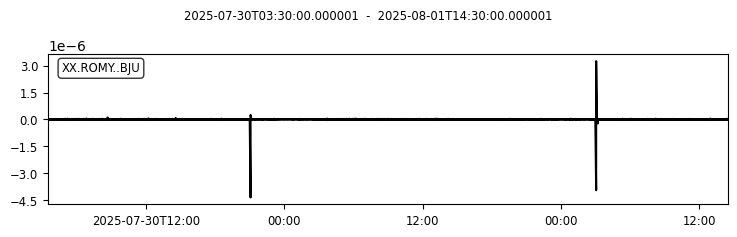

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  plt.setp(ax.get_xticklabels(), fontsize='small',


1 Trace(s) in Stream:
XX.ROMY..BJU | 2025-07-30T03:30:00.000001Z - 2025-08-01T14:30:00.000001Z | 20.0 Hz, 4248001 samples


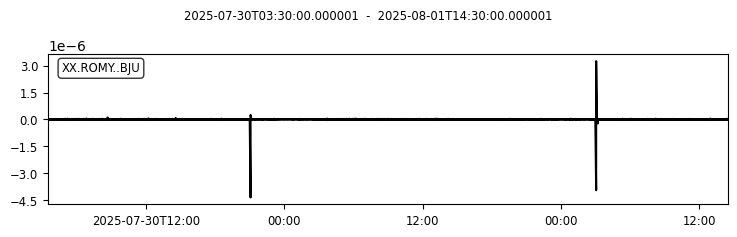

1 Trace(s) in Stream:
XX.ROMY..BJU | 2025-07-30T03:30:00.000001Z - 2025-08-01T14:30:00.000001Z | 20.0 Hz, 4248001 samples


In [17]:
component = "*JU"

st_before = sd.get_stream("rotation").select(channel=component)

# sort gaps in ascending order
gaps = sorted(gaps)

filled_stream = st_before.copy()
for gap in gaps:

    Twin = 2/0.0005

    # filled_stream = fill_gap_with_white_noise(
    #     filled_stream,
    #     gap[0],
    #     gap[1],
    #     window_size_sec=Twin,
    #     plot=True,
    #     method='frequency'
    # )

    # filled_stream = fill_gap_zeros(
    #     filled_stream,
    #     gap[0],
    #     gap[1],
    #     fill_value=0,
    #     plot=True
    # )

    # filled_stream = fill_gap_exponential(
    #     filled_stream,
    #     gap[0],
    #     gap[1],
    #     window_size_sec=Twin,
    #     seasonal_periods=Twin,
    #     plot=True,
    # )


sd.st.select(channel=component).plot()
print(sd.st.select(channel=component))

sd.st0.select(channel=component)[0].data = filled_stream[0].data
sd.st.select(channel=component)[0].data = filled_stream[0].data

sd.st.select(channel=component).plot()
print(sd.st.select(channel=component))

In [18]:
# from tiskitpy import Decimator

# decim = Decimator([5, 4])
# sd.st = decim.decimate(sd.st)

# print(sd.st)

## Analysis

In [19]:
# cut to usefuel data
sd.st.select(channel="*JU").trim(sd.tbeg+22*3600, sd.tend-21*3600)

1 Trace(s) in Stream:
XX.ROMY..BJU | 2025-07-30T21:30:00.000001Z - 2025-08-01T02:30:00.000001Z | 20.0 Hz, 2088001 samples

In [20]:
sd.st = sd.st.detrend(type="demean")
sd.st = sd.st.detrend(type="simple")

# sd.filter_data(fmin=0.0001, fmax=0.1, output=False)

# sd.st = sd.st.detrend(type="demean")
# sd.st = sd.st.detrend(type="simple")

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  plt.setp(ax.get_xticklabels(), fontsize='small',


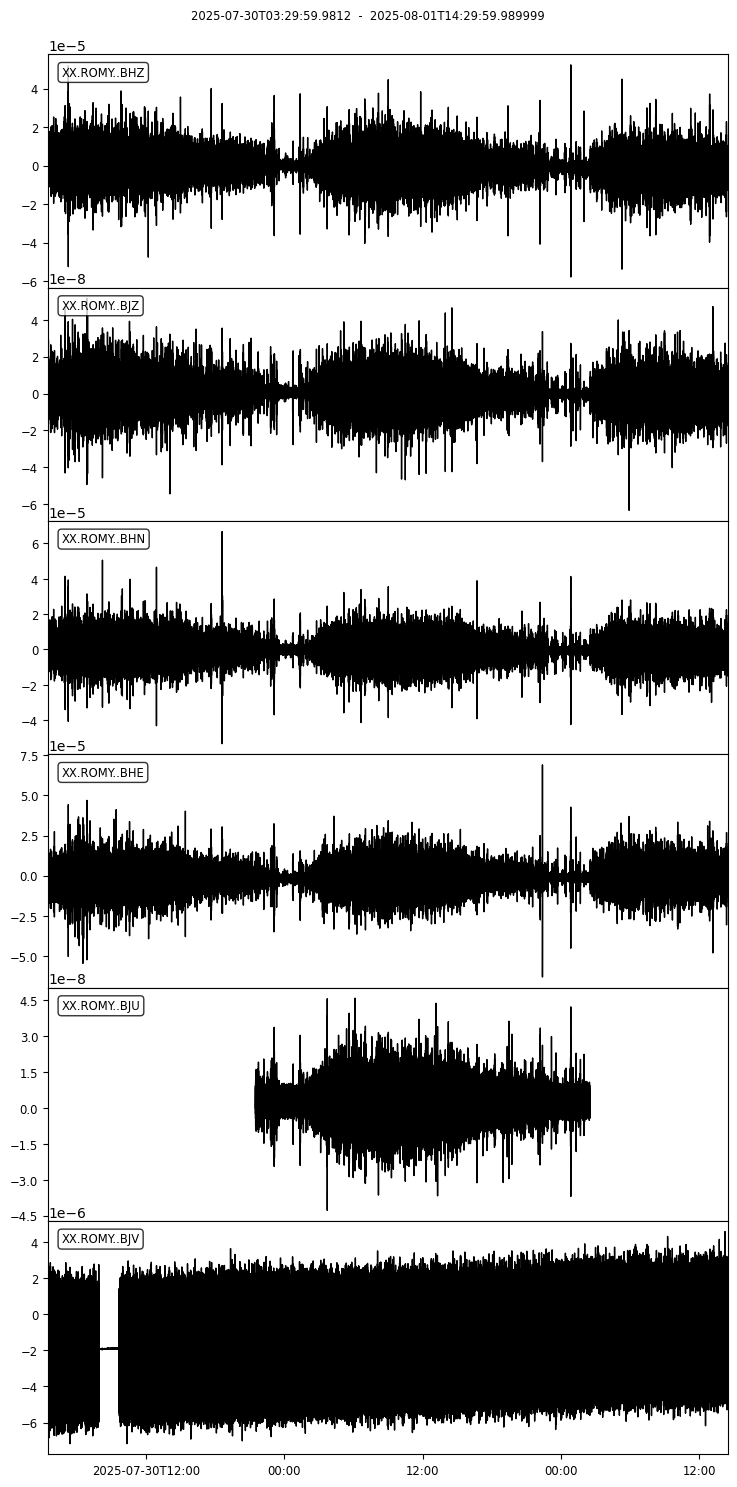

In [21]:
sd.st.plot(equal_scale=False, method="full");

In [22]:
# as modelled by RPEM in muHz
Smodes = {'0S2':309.28, '0S3':468.56, '0S4':647.07, '1S2':679.85, '0S0':814.31, 
            '0S5':840.42, '1S3':939.83, '3S1':943.95}

In [23]:
Tmodes = {
    "1T2": 1320.13,
    "1T3": 1439.13,
    "1T5": 1750.49,
    "1T6": 1925.61,
    "1T7": 2103.79,
    "1T13": 3100.46,
    "1T14": 3255.59,
    "2T3": 2294.97,
    "2T5": 2485.09,
    "2T7": 2753.73,
    "2T8": 2913.97,
    "2T13": 3832.88,
    "2T14": 4016.39,
    "2T15": 4196.12,
    "2T16": 4372.15,
    "3T1": 3203.50,
    "3T7": 3607.30,
    "3T16": 5054.35,
    "4T9": 4778.82,
}

In [24]:
channels = ['*JU','*JZ', '*HN', '*HE', '*HZ']

ffts = {}
for channel in channels:
    fft = sd.get_fft(
        sd.st.select(channel=channel)[0].data,
        dt=sd.st.select(channel=channel)[0].stats.delta,
        window='cosine'
    )
    ffts[channel] = fft


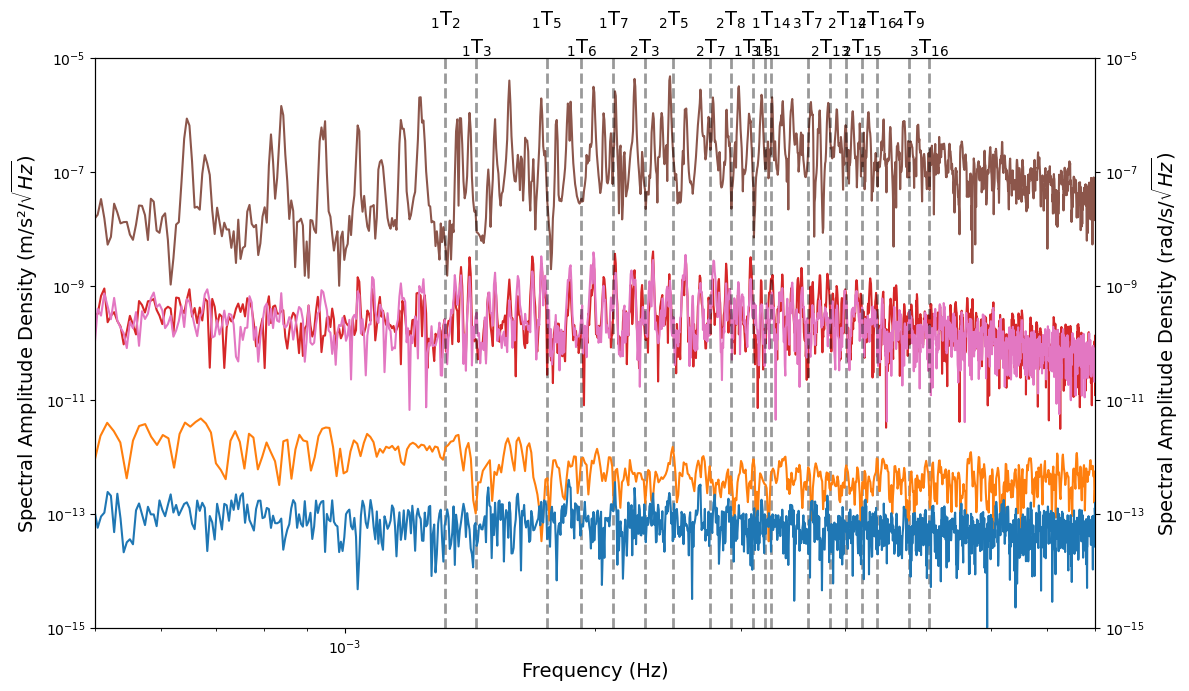

In [25]:
%matplotlib inline

colors = {
    "*JZ": "tab:blue",
    "*JU": "tab:orange",
    "*JE": "tab:green",
    "*HZ": "tab:brown",
    "*HN": "tab:red",
    "*HE": "tab:pink",
}

plt.figure(figsize=(12, 7))

ax1 = plt.gca()
ax2 = ax1.twinx()

for channel in channels:
    if "J" in channel:
        ax2.loglog(
            ffts[channel][0],
            ffts[channel][1],
            label=channel,
            color=colors[channel]
        )
    else:
        if "Z" in channel:
            offset = 1000
            ax1.loglog(
                        ffts[channel][0],
                        ffts[channel][1]*offset,
                        label=channel+"x1000",
                        color=colors[channel]
                    )
        else:
            offset = 1
            ax1.loglog(
                        ffts[channel][0],
                        ffts[channel][1]*offset,
                        label=channel,
                        color=colors[channel]
                    )

for mode in Tmodes.values():
    plt.axvline(mode*1e-6, color='black', zorder=0, alpha=0.4, lw=2, ls='--')

# plot mode labels at top
for i, (label, mode) in enumerate(Tmodes.items()):
    # format label with T ascaptialand numbers as subscript
    label = "$_{" + label.split("T")[0] + "}$T$_{" + label.split("T")[1] + "}$"
    # add vertcial pad to every second label
    if i%2 == 0:
        plt.text(mode*1e-6, 1e-5+2e-5, label, fontsize=14, color='black', ha='center', va='bottom')
    else:
        plt.text(mode*1e-6, 1e-5, label, fontsize=14, color='black', ha='center', va='bottom')

ax1.set_xlim(0.0005, 0.008)

ax1.set_xlabel(r'Frequency (Hz)', fontsize=14)
ax1.set_ylabel(r'Spectral Amplitude Density (m/s²/$\sqrt{Hz}$)', fontsize=14)
ax2.set_ylabel(r'Spectral Amplitude Density (rad/s/$\sqrt{Hz}$)', fontsize=14)

# ax1.grid(True, which="both", ls="-", alpha=0.3)

ax1.set_ylim(1e-15, 1e-5)
ax2.set_ylim(1e-15, 1e-5)

plt.tight_layout()

plt.show();

In [26]:
def compute_stacked_fft(stream, window_length_sec=3600, overlap_percent=50, taper_type='cosine', taper_percent=5, plot=True):
    """
    Compute stacked FFT from a stream using overlapping windows.
    
    Parameters
    ----------
    stream : obspy.Stream
        Input stream containing the data
    window_length_sec : float, optional
        Length of each window in seconds. Default is 3600 (1 hour)
    overlap_percent : float, optional
        Overlap between windows in percent. Default is 50
    taper_type : str, optional
        Type of taper to apply ('hann', 'hamming', 'blackman', etc.). Default is 'hann'
    taper_percent : float, optional
        Percentage of the window to taper. Default is 5
    plot : bool, optional
        If True, plots the stacked FFT. Default is True
        
    Returns
    -------
    tuple
        (frequencies, stacked_amplitude_spectrum, individual_spectra)
        frequencies: numpy array of frequency points
        stacked_amplitude_spectrum: numpy array of stacked amplitudes
        individual_spectra: list of individual window spectra
    """
    import numpy as np
    from scipy import signal
    import matplotlib.pyplot as plt
    
    # Process each trace in the stream
    for tr in stream:
        # Get sampling parameters
        sampling_rate = tr.stats.sampling_rate
        dt = 1.0 / sampling_rate
        
        # Calculate window parameters in samples
        window_samples = int(window_length_sec * sampling_rate)
        overlap_samples = int(window_samples * overlap_percent / 100)
        step_samples = window_samples - overlap_samples
        
        # Create window function
        window = signal.get_window(taper_type, window_samples)
        
        # Calculate number of windows
        n_windows = (len(tr.data) - overlap_samples) // step_samples
        
        # Initialize lists for spectra
        spectra = []
        
        # Process each window
        for i in range(n_windows):
            # Extract window data
            start_idx = i * step_samples
            end_idx = start_idx + window_samples
            
            if end_idx > len(tr.data):
                break
                
            data_window = tr.data[start_idx:end_idx]
            
            # Apply window function
            windowed_data = data_window * window
            
            # Compute FFT
            fft = np.fft.rfft(windowed_data)
            freq = np.fft.rfftfreq(len(windowed_data), d=dt)
            
            # Compute amplitude spectrum
            amplitude_spectrum = np.abs(fft)
            
            # Normalize by window length
            amplitude_spectrum /= len(windowed_data)
            
            # Store spectrum
            spectra.append(amplitude_spectrum)
        
        # Convert to numpy array for easier manipulation
        spectra = np.array(spectra)
        
        # Compute mean (stacked) spectrum
        stacked_spectrum = np.mean(spectra, axis=0)
        
        # Compute standard deviation for error bars
        spectrum_std = np.std(spectra, axis=0)
        
        if plot:
            # Create figure
            plt.figure(figsize=(12, 8))
            
            # Plot mean spectrum with error region
            plt.loglog(freq, stacked_spectrum, 'k-', label='Stacked Spectrum', linewidth=2)
            plt.fill_between(freq, 
                           stacked_spectrum - spectrum_std,
                           stacked_spectrum + spectrum_std,
                           color='gray', alpha=0.3, label='±1σ')
            
            # Plot individual spectra with low opacity
            for spectrum in spectra:
                plt.loglog(freq, spectrum, 'b-', alpha=0.1)
            
            plt.grid(True, which="both", ls="-", alpha=0.2)
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Amplitude')
            plt.title(f'Stacked FFT - {tr.id}\n'
                     f'Window Length: {window_length_sec}s, Overlap: {overlap_percent}%')
            plt.legend()
            plt.show()
            
            # Plot spectrogram
            plt.figure(figsize=(12, 6))
            times = np.arange(n_windows) * (window_length_sec * (1 - overlap_percent/100))
            plt.pcolormesh(times, freq, spectra.T, 
                          shading='gouraud', cmap='viridis')
            plt.yscale('log')
            plt.colorbar(label='Amplitude')
            plt.xlabel('Time [s]')
            plt.ylabel('Frequency [Hz]')
            plt.title(f'Spectrogram - {tr.id}')
            plt.show()
        
        return freq, stacked_spectrum, spectra

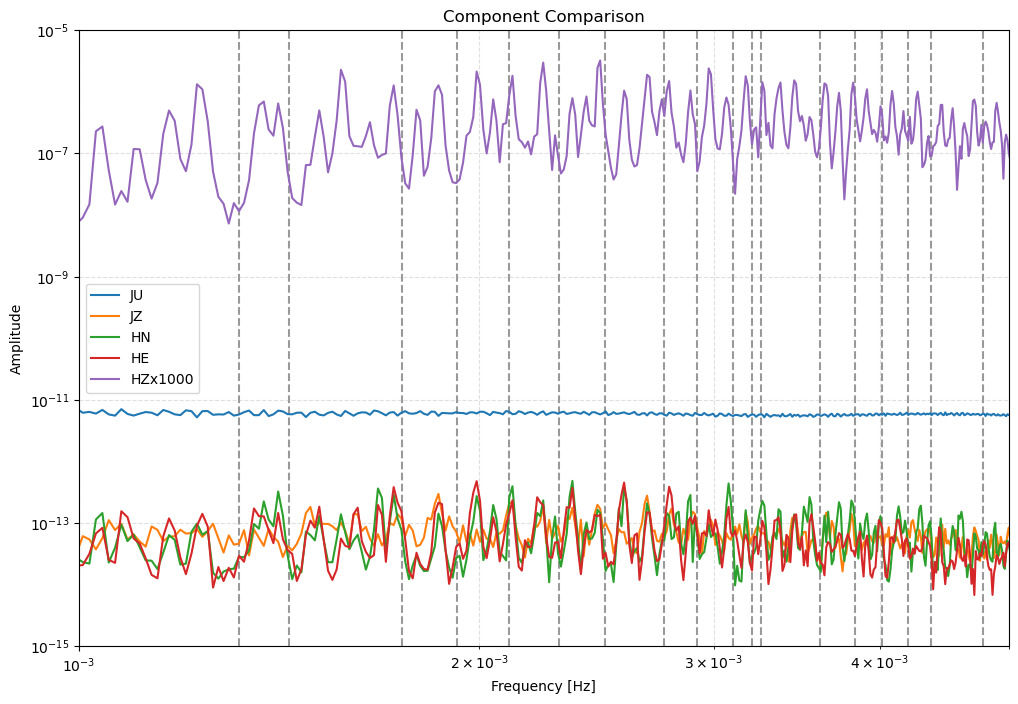

In [ ]:
channels = ['*JU', '*JZ', '*HN', '*HE', '*HZ']

plt.figure(figsize=(12, 8))

for component in channels:
    freq, spectrum, _ = compute_stacked_fft(
        sd.st.select(channel=component),
        window_length_sec=24*3600,
        overlap_percent=50,
        plot=False  # Don't show individual plots
    )

    if "HZ" in component:
        offset = 1000
        plt.loglog(freq, spectrum*offset, label=component[1:]+"x1000")
    else:
        offset = 1
        if "H" in component:
            plt.loglog(freq, spectrum*offset/(2*3000), label=component[1:])
        else:
            plt.loglog(freq, spectrum*offset, label=component[1:])

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Component Comparison')


for mode in Tmodes.values():
    plt.axvline(mode*1e-6, color='k', zorder=0, alpha=0.4, ls='--')

plt.minorticks_on()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.xlim(0.0005, 0.01)
plt.xlim(0.001, 0.005)

plt.ylim(1e-15, 1e-5)
plt.legend()
plt.show()

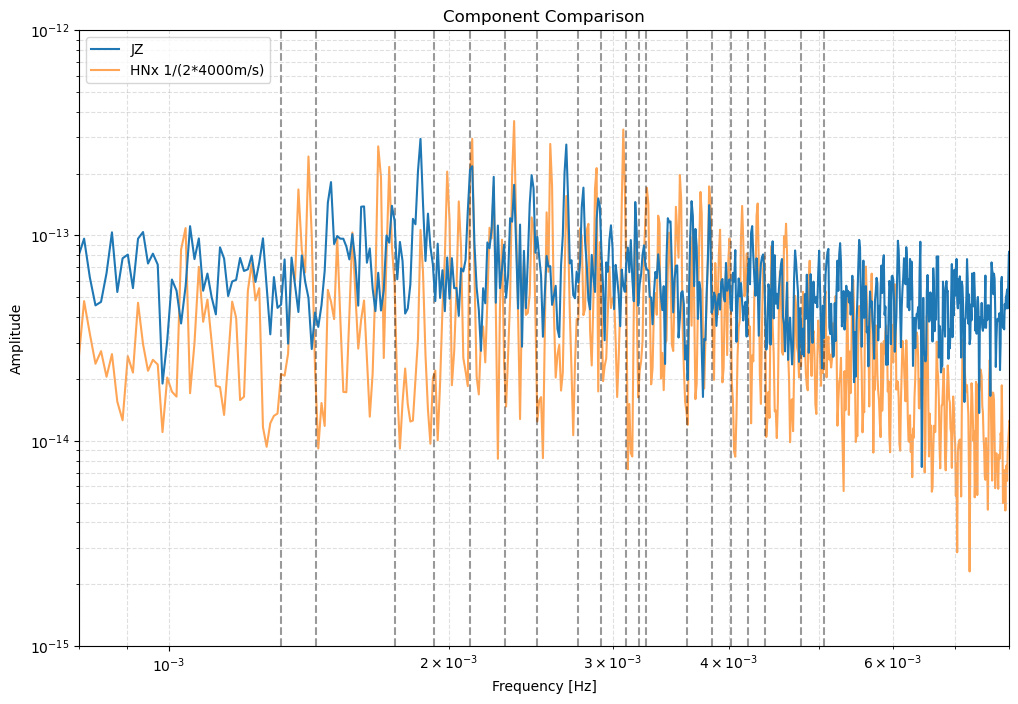

In [42]:
channels = ['*JZ', '*HN']

plt.figure(figsize=(12, 8))

for component in channels:
    freq, spectrum, _ = compute_stacked_fft(
        sd.st.select(channel=component),
        window_length_sec=24*3600,
        overlap_percent=50,
        plot=False  # Don't show individual plots
    )

    if "HZ" in component:
        offset = 1000
        plt.loglog(freq, spectrum*offset, label=component[1:]+"x1000")
    else:
        offset = 1
        if "H" in component:
            plt.loglog(freq, spectrum*offset/(2*4000), label=component[1:]+"x 1/(2*4000m/s)", zorder=0, alpha=0.7)
        else:
            plt.loglog(freq, spectrum*offset, label=component[1:])

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Component Comparison')


for mode in Tmodes.values():
    plt.axvline(mode*1e-6, color='k', zorder=0, alpha=0.4, ls='--')

plt.minorticks_on()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.xlim(0.0008, 0.008)
# plt.xlim(0.001, 0.005)

plt.ylim(1e-15, 1e-12)
plt.legend()
plt.show()

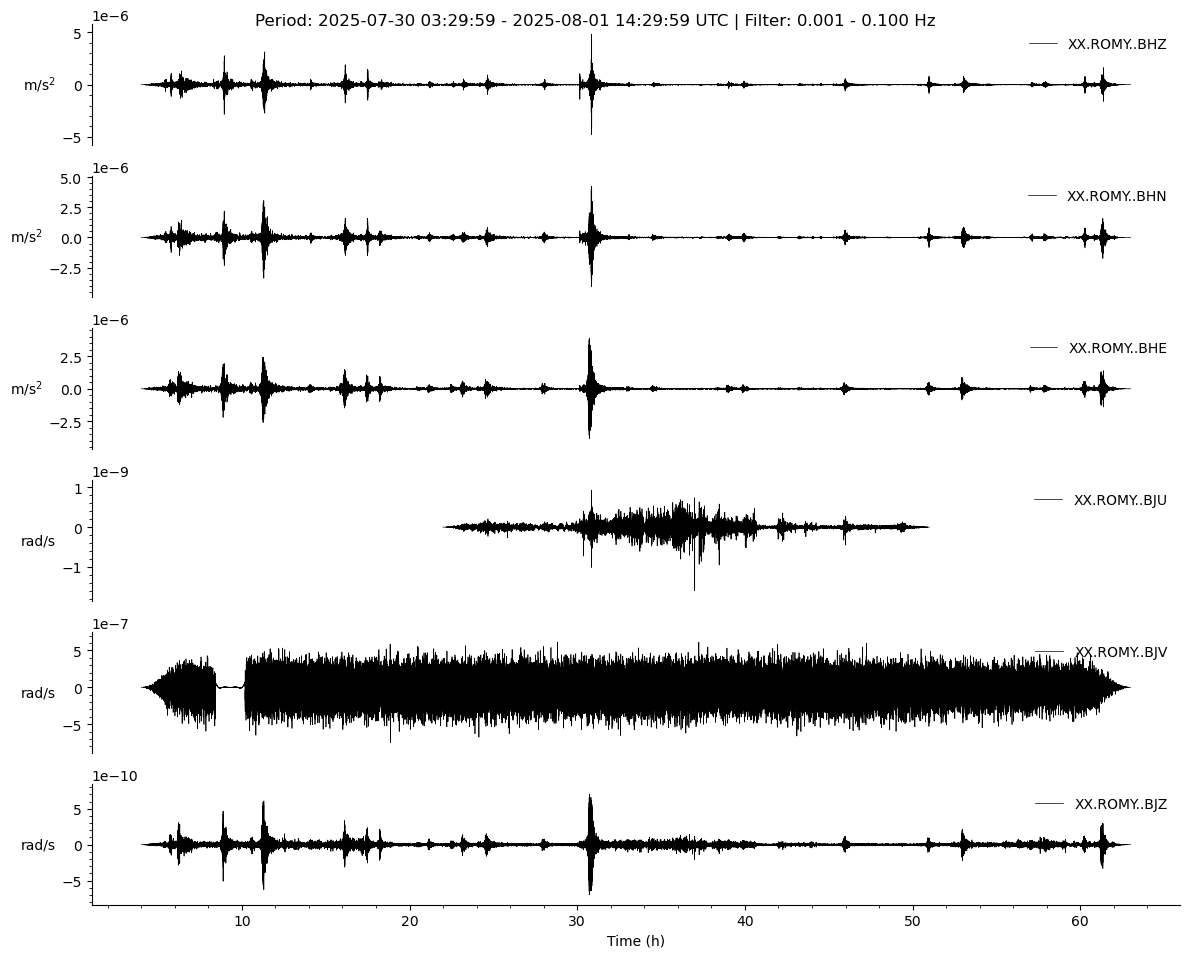

In [28]:
sd.st0.select(channel="*JU").trim(sd.tbeg+22*3600, sd.tend-21*3600)

sd.st = sd.st.detrend(type="demean")
sd.st = sd.st.detrend(type="simple")

sd.filter_data(fmin=0.0005, fmax=0.1, output=False)

sd.st = sd.st.detrend(type="demean")
sd.st = sd.st.detrend(type="simple")

fig = sd.plot_waveforms(time_scale="hours", ybounds={"BJU": (-1e-8, 1e-8)})

### Check for one component how much data is needed 

In [29]:
config = sixdegrees.load_from_yaml("./config/config_ROMY_M8.8_20250729")

sd = sixdegrees(conf=config)

st_load = obs.read("./data/romy_eigenmodes.mseed")

sd.st0 = st_load
sd.st = st_load

del st_load

sd.trim_stream(set_common=True, set_interpolate=False)

sd.st.trim(sd.tbeg+4*3600, sd.tend-9*3600)


 -> stream size inconsistent: [5184041, 5184041, 5184041, 5184041, 5184040, 5184041]
  -> adjusted: [5184040, 5184040, 5184040, 5184040, 5184040, 5184040]


6 Trace(s) in Stream:
XX.ROMY..BHZ | 2025-07-30T03:29:59.989999Z - 2025-08-01T14:29:59.989999Z | 20.0 Hz, 4248001 samples
XX.ROMY..BHN | 2025-07-30T03:29:59.989999Z - 2025-08-01T14:29:59.989999Z | 20.0 Hz, 4248001 samples
XX.ROMY..BHE | 2025-07-30T03:29:59.989999Z - 2025-08-01T14:29:59.989999Z | 20.0 Hz, 4248001 samples
XX.ROMY..BJU | 2025-07-30T03:30:00.000001Z - 2025-08-01T14:30:00.000001Z | 20.0 Hz, 4248001 samples
XX.ROMY..BJV | 2025-07-30T03:29:59.981200Z - 2025-08-01T14:29:59.981200Z | 20.0 Hz, 4248001 samples
XX.ROMY..BJZ | 2025-07-30T03:29:59.985200Z - 2025-08-01T14:29:59.985200Z | 20.0 Hz, 4248001 samples

In [30]:
jz = sd.st.select(channel="*HN").copy()

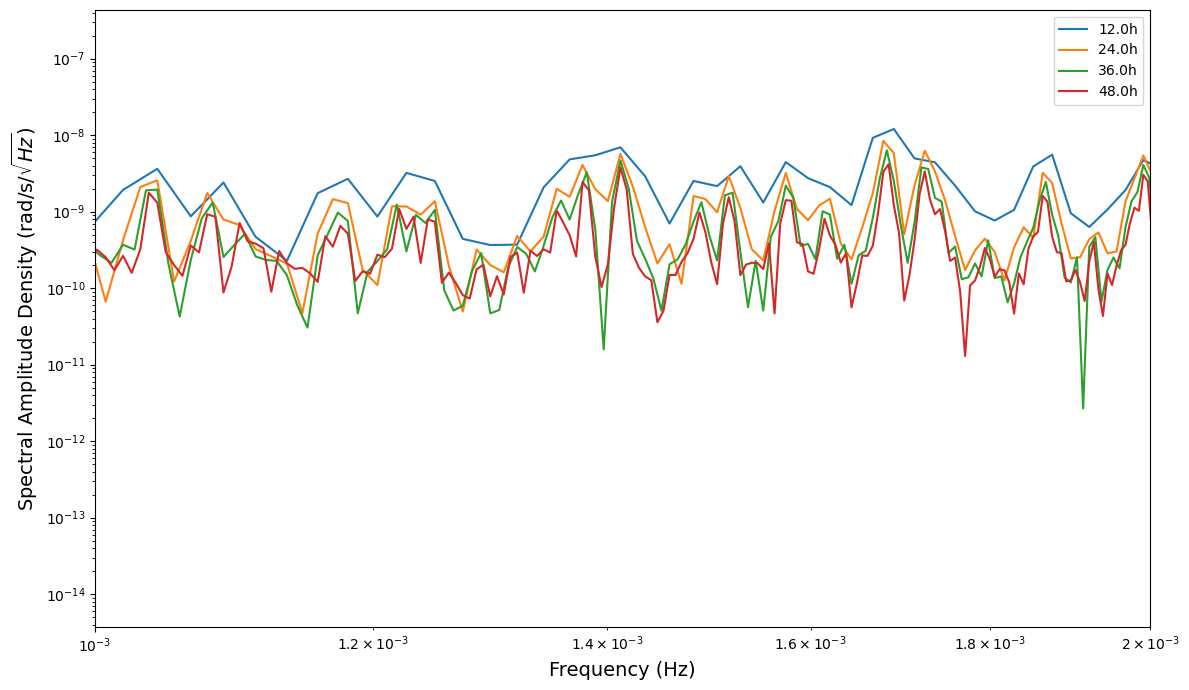

In [31]:
deltaT = 12*3600

tend = jz[0].stats.starttime + deltaT

ffts = {}
time = []
i = 0
while tend < jz[0].stats.endtime:

    _jz = jz.copy().trim(jz[0].stats.starttime, tend)

    fft = sd.get_fft(
        _jz[0].data,
        dt=_jz[0].stats.delta,
        window='cosine'
    )
    ffts[i] = fft
    time.append(tend - jz[0].stats.starttime)
    i += 1

    tend += deltaT


plt.figure(figsize=(12, 7))

ax1 = plt.gca()

for i in range(len(ffts)):
    ax1.loglog(
        ffts[i][0],
        ffts[i][1],
        label=str(time[i]/3600)+"h"
    )


ax1.set_xlabel(r'Frequency (Hz)', fontsize=14)
ax1.set_ylabel(r'Spectral Amplitude Density (rad/s/$\sqrt{Hz}$)', fontsize=14)

# ax1.set_ylim(1e-15, 1e-11)

ax1.set_xlim(0.0005, 0.008)
ax1.set_xlim(0.001, 0.002)


plt.legend()

plt.tight_layout()

plt.show();